**Allan Reuben 260783324**
# **ECSE 415 Assigment 3**

# Part 1: Data

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import concurrent.futures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import LinearSVC
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')
# Change this path to run with files in a different location
path = '/content/drive/My Drive/ECSE415/Assignment-3/'
root = path + 'Color_FERET_Database/'


# Setting random seed for testing, comment out for a randomized run
random.seed(444)

Mounted at /content/drive


1.1: Convert images to gray-scale and down-sample images by the scale of 4.

In [2]:
def loadAndResize(path):
  # Load image in grayscale
  image = cv2.imread(path, 0)
  # Downsample image by 4x. Given dimensions are 768x512 so resized would be 192x128
  image = image.astype('float64')
  return cv2.resize(image, (128,192))


subjectPaths = [os.path.join(root, subpath) for subpath in os.listdir(root)]
imagePaths = []
subjectImages = []
images = []
i = 0

# Using process pool executor. Sources for inspiration below
# https://stackoverflow.com/questions/48532411/how-do-i-wait-for-threadpoolexecutor-map-to-finish/48534215
# https://pymotw.com/3/concurrent.futures/
# https://docs.python.org/3/library/concurrent.futures.html

# Process pool executor allows for multiprocessing and a massive speedup of the loading operation
# Also using tqdm to show a progress bar
executor = concurrent.futures.ProcessPoolExecutor(max_workers=16)
for subjectPath in tqdm(subjectPaths):
  # Find the path of every image per subject
  imagePaths.append([os.path.join(subjectPath, subpath) for subpath in os.listdir(subjectPath)])
  length = len(imagePaths[i]) - 1
  # Load every image by subject, process pool executor waits for all to finish before continuing
  # Using map to call loadAndResize many times concurrently
  # imagePaths[i] is a list of all the image paths for subject i
  subjectImages = list(executor.map(loadAndResize, imagePaths[i]))
  # Add images to larger list of images
  images.append(subjectImages)
  i += 1

100%|██████████| 52/52 [01:49<00:00,  2.10s/it]


1.2: Train set: For each subject, randomly select 80% of the total images given for that subject. This will be used as the training set.

1.3: Test set: All the remaining images from the given subset which are not
used in the training set will be used as test images.

In [3]:
trainSet = []
testSet = []
# Create lists of subject numbers to keep track of frequency for histograms
trainFrequency = []
testFrequency = []
N = 0 # Number of images in train set
i = 0 # Keep track of the subject number

for subject in images:
  # Init temporary lists
  trainFreqAdd = []
  testFreqAdd = []
  # Shuffle the images for each subject randomly
  random.shuffle(subject)

  # Split the images for each subject 80% for training and 20% for test
  # Splits are rough as the elements may not map perfectly into 80% and 20%
  trainLength = round(len(subject) * 0.8)
  trainSet.append(subject[:trainLength])
  testSet.append(subject[trainLength:])
  testLength = len(subject) - trainLength
  trainFreqAdd = [i] * trainLength
  testFreqAdd = [i] * testLength
  trainFrequency.extend(trainFreqAdd)
  testFrequency.extend(testFreqAdd)
  N += trainLength
  i += 1

1.4: Display total 10 random images. Plot histogram of the frequency of each
image class (in this case the subject) distribution.

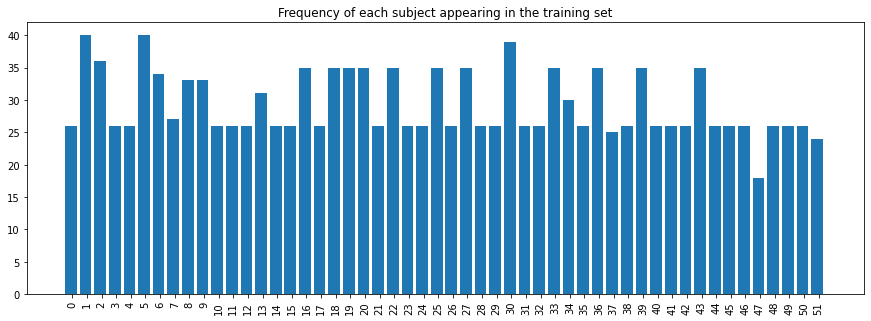

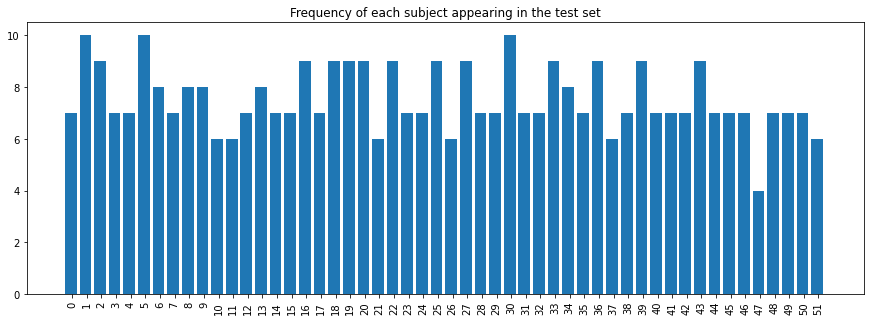

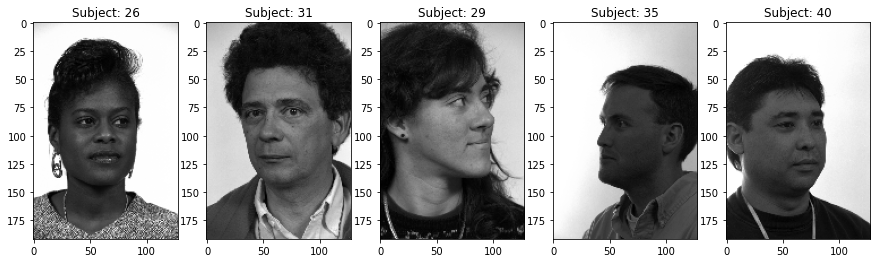

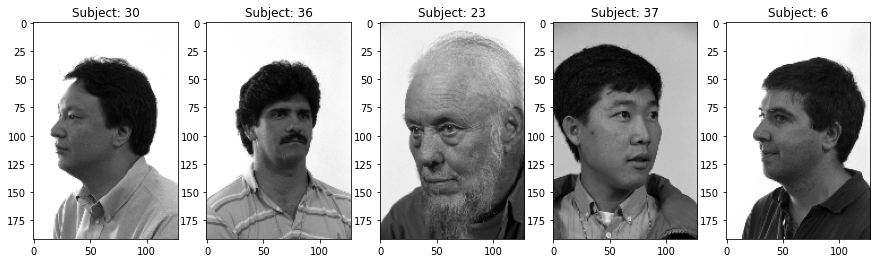

In [4]:
# Choose 10 random images from training set
randomTen = []
subjectTracker = []
for i in range(10):
  x = random.randint(0,51)
  y = random.randint(0,len(trainSet[x]) - 1)
  subjectTracker.append(x)
  randomTen.append(trainSet[x][y])

# Plot the histograms

plt.figure(figsize=(15,5))
plt.hist(trainFrequency, bins=np.arange(53) - 0.5, width = 0.8)
plt.title("Frequency of each subject appearing in the training set")
plt.xticks(ticks = np.arange(52), labels=np.arange(52), rotation='vertical')
plt.show()

plt.figure(figsize=(15,5))
plt.hist(testFrequency, bins=np.arange(53) - 0.5, width = 0.8)
plt.title("Frequency of each subject appearing in the test set")
plt.xticks(ticks = np.arange(52), labels=np.arange(52), rotation='vertical')
plt.show()

# Plot the 10 random images

plt.figure(figsize=(15,15))
plt.subplot(151), plt.imshow(randomTen[0], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[0]))
plt.subplot(152), plt.imshow(randomTen[1], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[1]))
plt.subplot(153), plt.imshow(randomTen[2], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[2]))
plt.subplot(154), plt.imshow(randomTen[3], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[3]))
plt.subplot(155), plt.imshow(randomTen[4], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[4]))
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(151), plt.imshow(randomTen[5], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[5]))
plt.subplot(152), plt.imshow(randomTen[6], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[6]))
plt.subplot(153), plt.imshow(randomTen[7], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[7]))
plt.subplot(154), plt.imshow(randomTen[8], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[8]))
plt.subplot(155), plt.imshow(randomTen[9], cmap='gray')
plt.title(f"Subject: " + str(subjectTracker[9]))
plt.show()

# Part 2: Eigenface Representation

2.1: Implement the efficient Snap- shot method for PCA (covered in class, Lecture 9, Slide 55) from scratch using numpy.

**N.B. The PCA function and this block takes a long time to run, this length is because of the line that computes the 1523 best eigenvectors of D * DTranspose**

In [5]:
# Method for computing eigenfaces described in http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf
def PCA(DTranspose):
  # At this point, DTranspose is a matrix of all images (rows as images, columns as dimensions)
  # We now find the mean face vector
  mean = np.mean(DTranspose, axis=0)

  # And now subtract the mean face vector from each image vector to centre the data
  DTranspose = DTranspose - mean

  # Now calculate the tranpose to get the matrix D
  D = np.transpose(DTranspose)

  # DDTranspose will be very large so we want to use DTransposeD (DTD) which will have shape (1523, 1523)
  DTD = np.matmul(DTranspose, D)

  # Now get eigenvalues and eigenvectors of DTD
  eigenvalues, eigenvectors = np.linalg.eig(DTD)
  # We want to use this to compute the best 1523 eigenvectors of DDT (the large covariance matrix)
  # The eigenvalues are identical, so no need to recompute them
  # This next line takes a long time to run
  eigenvectorsDDT = np.matmul(D, eigenvectors)

  # We now want to normalize each eigenvector so the magnitude = 1
  eigenvectorNorm = np.empty_like(eigenvectorsDDT)
  norm = np.linalg.norm(eigenvectorsDDT, axis=0)
  for i in range(N):
    eigenvectorNorm[:,i] = eigenvectorsDDT[:,i] / norm[i]

  # Rows are now vectors, columns are dimensions for simpler computation
  eigenvectorsSorted = np.transpose(eigenvectorNorm)
  # Sort the eigenvalues and eigenvectors
  eigenvectorsSorted = [eigenvectorsSorted for _,eigenvectorsSorted in sorted(zip(eigenvalues,np.transpose(eigenvectorNorm)), reverse = True)]
  eigenvaluesSorted = sorted(eigenvalues, reverse = True)

  # Calculate weights
  weights = np.matmul(eigenvectorsSorted, D)

  # Transpose back
  eigenvectorsSorted = np.transpose(eigenvectorsSorted)
  weights = np.transpose(weights)

  # Now return the eigenvalues and eigenvectors
  return eigenvaluesSorted, eigenvectorsSorted, weights

# We want to convert each image to a vector of intensities and find the mean face vector
pixelSpaceVectors = []
imageVector = []
for imagesPerSubject in trainSet:
  for image in imagesPerSubject:
    # Convert the image into a vector and add it to the set D
    # This flattens it into a 1D row vector, technically the transpose of what we want (as per Lecture 9 Slide 15)
    imageVector = image.flatten()

    # Add the image in vector format to pixelSpaceVectors as it is the set of image vectors
    # imageVector is a transpose, so we add it to the transposed matrix
    pixelSpaceVectors.append(imageVector)

pixelSpaceVectors = np.asarray(pixelSpaceVectors)

eigenvalues, eigenvectors, weights = PCA(pixelSpaceVectors)

2.2: Plot the fraction of total variance against the number of eigenvectors

2.3: Plot the normalized variance (eigenvalues) against the eigenvector index used for computation.

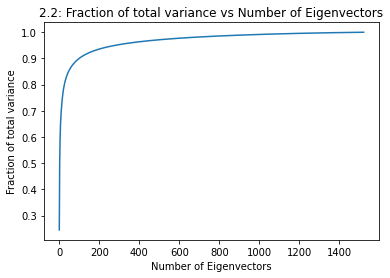

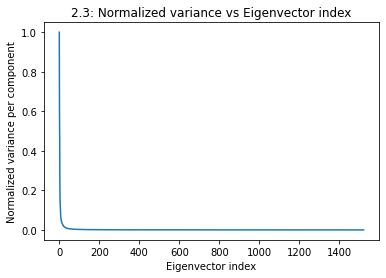

In [6]:
# Variance ratio
plt.figure()
plt.plot(np.cumsum(eigenvalues) / np.sum(eigenvalues))
plt.title("2.2: Fraction of total variance vs Number of Eigenvectors")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Fraction of total variance")
plt.show()

# Normalized eigenvalues
normEigenvalues = eigenvalues / np.max(eigenvalues)
plt.figure()
plt.plot(normEigenvalues)
plt.title("2.3: Normalized variance vs Eigenvector index")
plt.xlabel("Eigenvector index")
plt.ylabel("Normalized variance per component")
plt.show()

2.4: Do you need all the vectors to represent the data? Discuss

No we do not need all the vectors to represent the data accurately. As most of the variance is contained within the first few vectors, we can keep only the best few (K) vectors and still have an accurate representation of the data. Dropping most of the vectors (that contain a small minority of the variance) will greatly simplify the computations that need to be made, and will reduce the likelihood of overfitting.

2.5: Display the first 5 eigenfaces

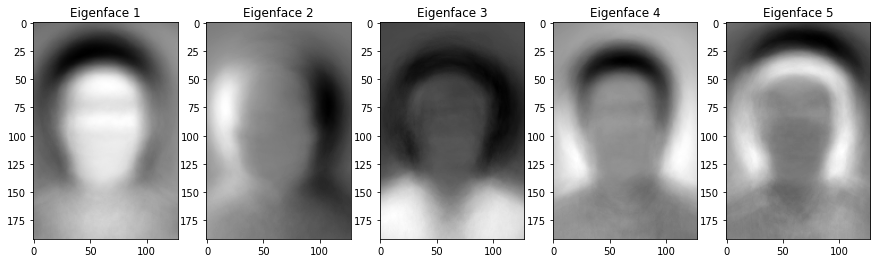

In [7]:
eigenfaces = np.transpose(eigenvectors)

plt.figure(figsize=(15,15))
plt.subplot(151), plt.imshow(np.reshape(eigenfaces[0], (192,128)), cmap='gray')
plt.title("Eigenface 1")
plt.subplot(152), plt.imshow(np.reshape(eigenfaces[1], (192,128)), cmap='gray')
plt.title("Eigenface 2")
plt.subplot(153), plt.imshow(np.reshape(eigenfaces[2], (192,128)), cmap='gray')
plt.title("Eigenface 3")
plt.subplot(154), plt.imshow(np.reshape(eigenfaces[3], (192,128)), cmap='gray')
plt.title("Eigenface 4")
plt.subplot(155), plt.imshow(np.reshape(eigenfaces[4], (192,128)), cmap='gray')
plt.title("Eigenface 5")
plt.show()

# Part 3: Classification


3.1: For every testing image, find the nearest neighbour (L2 distance), and check whether both images belong to the same person. To estimate the accuracy of this approach, determine what fraction of your test images has a neighbour that is actually of the same person? Compute the accuracy both in the original high dimensional pixel space and then in the eigenspace, and compare the accuracy values. Would you expect there to be a significant difference?

In my tests, the computed accuracy was roughly 67.7% in pixel space and 69.7% in eigenspace with K = 210. I would not expect there to be a significant difference between the two, as PCA is designed to contain most of the variation between faces in a much smaller amount of data.

In [8]:
# Source for using knn_classifier: https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn

# Create lists to identify subjects within flattened set
trainSubjectsList = []
# For every subject
for i in range(len(trainSet)):
  for j in range(len(trainSet[i])):
    trainSubjectsList.append(i)

testSubjectsList = []
# For every subject
for i in range(len(testSet)):
  for j in range(len(testSet[i])):
    testSubjectsList.append(i)

# Flatten the test set, train set is already flattened as pixelSpaceVectors
testTranspose = []
for imagesPerSubject in testSet:
  for image in imagesPerSubject:
    # Convert the image into a vector and add it to the set of flattened vectors
    imageVector = image.flatten()
    testTranspose.append(imageVector)

# Create L2 classifier, fit it, and make predictions
knn_classifier = KNeighborsClassifier(n_neighbors=1,metric='l2')
knn_classifier.fit(pixelSpaceVectors, trainSubjectsList)
px_pred = knn_classifier.predict(testTranspose)
pxaccuracy = metrics.accuracy_score(testSubjectsList, px_pred)*100

print(f'Pixel space classification accuracy: ' + str(pxaccuracy) + "%")

# Eigenspace classifier 
# Calculate mean and subtract
mean = np.mean(pixelSpaceVectors, axis=0)
testNorm = testTranspose - mean
# Calculate the weights, keeping 210 of 1523
K=210
testWeights = np.matmul(testNorm, eigenvectors[:,:K])

# Refit classifier and make predictions, again L2 distance
knn_classifier.fit(weights[:,:K], trainSubjectsList)
eg_pred = knn_classifier.predict(testWeights)
egaccuracy = metrics.accuracy_score(testSubjectsList, eg_pred)*100
print(f'Eigenspace classification accuracy: ' + str(egaccuracy) + "%")

Pixel space classification accuracy: 67.68447837150127%
Eigenspace classification accuracy: 69.72010178117048%


3.2: You will now use a linear SVM classifier in the eigenspace. Use the training dataset to fit the classifier and the testing dataset to test the classifier. Compare the accuracy of this classifier with the nearest neighbour classifier used previously.

In my tests, the linear SVM classifier had an accuracy of 76.8%, which is much better than the nearest neighbour classifier.

In [9]:
from sklearn import svm
# Linear SVM classifier
clf = svm.SVC(kernel='linear')

# Calculate the weights, keeping 210 of 1523
K=210
testWeights = np.matmul(testNorm, eigenvectors[:,:K])

clf.fit(weights[:,:K], trainSubjectsList)
svm_pred = clf.predict(testWeights)
svm_accuracy = metrics.accuracy_score(testSubjectsList, svm_pred)*100
print(f'SVM classification accuracy: ' + str(svm_accuracy) + "%")

SVM classification accuracy: 76.84478371501272%


# Part 4: Face Detection


4.1: Use a sliding window to detect the faces. Set a threshold on the distance in eigenspace between the window contents and your training data (Refer to slide 63 of Lecture 9). Try different values of thresholds and use the one which gives you good results. Display your image with bounding boxes around the detected faces for the best threshold.


After computing the face detection with PCA and a sliding window, we get that the true positive faces lie quite far (at a distance of 2500-4500 depending on K) from the face space. I am unsure why this is the case, but with smaller thresholds, we have 3-4 false negatives and many false positives. The false positives that are detected are mostly in flat regions of the same colour, suggesting that the eigenfaces or reconstruction may be incorrect (however during reconstruction of faces that I attempted results were very good).

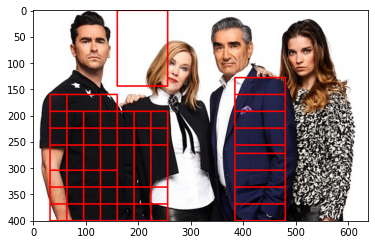

In [10]:
# Pyramid/Sliding window source: https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
# Method for detecting faces described in http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf

# import the necessary packages
import imutils
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

def sliding_window(image, stepSize, windowSize):
	# Slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# Yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def face_detect(image, mean, eigenfaces, K):
  # Here we want to compute the mean-normalized image (phi), the reduced and reconstructed image (phi hat), and 
  phi = image.flatten() - mean
  weights = np.matmul(phi, eigenfaces[:,:K])
  phiHat = np.transpose(np.dot(eigenfaces[:,:K], weights[:K]))
  norm = np.linalg.norm(phi - phiHat)
  return norm


# Load image for face detection
schittsCreek = cv2.imread(path + 'Schitts_Creek_group.jpg')
schittsCreek = cv2.cvtColor(schittsCreek, cv2.COLOR_BGR2RGB)
schittsGray = cv2.cvtColor(schittsCreek, cv2.COLOR_RGB2GRAY)
schittsGray = schittsGray.astype('float64')

(winW,winH) = (96,144)
threshold = 3000
K = 210

# Now slide the window (of size 192x128) over the image to get 
for (x, y, window) in sliding_window(schittsGray, stepSize=32, windowSize=(winW, winH)):
  # If the window meets our desired window size, compute for faces on it
  if (window.shape[0] == winH) and (window.shape[1] == winW):
    window = cv2.resize(window, (128,192))
    norm = face_detect(window, mean, eigenvectors, K)
    # If the norm is less than our threshold draw a rectancle around the face
    if norm < threshold:
      result = cv2.rectangle(schittsCreek, (x, y), (x + winW, y + winH), (255, 0, 0), 2)

# Plot the image with faces on it
plt.figure()
plt.imshow(result)
plt.show()


4.2: Use an existing implementation of the Viola-Jones face detector, and compare the results with your detector. Comparisons should be made in terms of the number of true positives, false positives and false negatives. Display the image with bounding boxes around the detected faces. Under what conditions would you expect the Viola-Jones detector to work when PCA does not?

In the viola jones detector, we have 4 true positives and 0 false positives and 0 false negatives. We would expect that the Viola-Jones detector would work better than PCA in real time applications where computation time is an important factor in facial recognition.

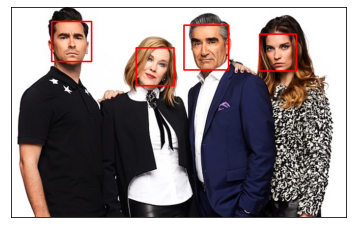

In [11]:
# Load image for face detection
schittsCreek = cv2.imread(path + 'Schitts_Creek_group.jpg')
schittsCreek = cv2.cvtColor(schittsCreek, cv2.COLOR_BGR2RGB)
schittsGray = cv2.cvtColor(schittsCreek, cv2.COLOR_RGB2GRAY)

# Code for Viola-Jones face detector taken from tutorial 5 jupyter notebook
face_cascade = cv2.CascadeClassifier(path+'haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(schittsGray, 1.2, 2)

for (x,y,w,h) in faces:
  # Draw a rectancle around the faces
  creek = cv2.rectangle(schittsCreek,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(creek, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()